In [1]:
import os
from pathlib import Path
import sys
from typing import Dict, List, Tuple

import h5py
import lightning
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

project_root = Path('/home/yianchen/NTUHEPML-CWoLa')
npy_path = project_root / 'npy_dataset'
os.makedirs(npy_path, exist_ok=True)

np.set_printoptions(linewidth=np.inf, threshold=np.inf)  # comment out to disable

In [2]:
def wrap_pi(phi: np.ndarray | torch.Tensor) -> np.ndarray | torch.Tensor:
    """Wrap angles to [-pi, pi)."""
    return (phi + np.pi) % (2 * np.pi) - np.pi

In [3]:
class MCSimData:
    def __init__(self, path: str | Path, include_decay=True):
        self.path = str(path)
        self.include_decay = include_decay

        with h5py.File(str(path), 'r') as hdf5_file:
            # -------- Jet flavor --------
            self.jet_flavor = self._extract_jet_flavor(hdf5_file)

            # -------- Channels --------
            if 'diphoton' in self.path:
                decay_channel = ['PHOTON']
            elif 'zz4l' in self.path:
                decay_channel = ['LEPTON']
            detector_channels = ['TOWER', 'TRACK']

            # -------- Particle flow information (pt, eta, phi) --------
            if include_decay:
                self.channels = detector_channels + decay_channel
                particle_flow = self._extract_particle_flow(hdf5_file, self.channels)
            else:
                self.channels = detector_channels
                detector_particle_flow = self._extract_particle_flow(hdf5_file, detector_channels)
                decay_particle_flow = self._extract_particle_flow(hdf5_file, decay_channel)
                particle_flow = self._exclude_decay_information(detector_particle_flow, decay_particle_flow, decay_channel[0])
        
        # -------- Preprocess: center φ per event (weighted circular mean) --------
        np.save(npy_path / f'original_data.npy', particle_flow)
        particle_flow = self._preprocess_phi_transformation(particle_flow)
        np.save(npy_path / f'data_phivar.npy', particle_flow)
        particle_flow = self._preprocess_center_of_phi(particle_flow)
        np.save(npy_path / f'data_phivar_cop.npy', particle_flow)
        particle_flow = self._preprocess_flipping(particle_flow)
        np.save(npy_path / f'data_phivar_cop_flip.npy', particle_flow)
        self.data = particle_flow

    def _extract_jet_flavor(self, hdf5_file: h5py.File) -> Dict[str, torch.Tensor | int]:
        """Build gluon/quark composition masks from J1/J2 flavors."""
        J1 = torch.as_tensor(hdf5_file["J1"]["flavor"][:], dtype=torch.long)
        J2 = torch.as_tensor(hdf5_file["J2"]["flavor"][:], dtype=torch.long)
        g1, g2 = (J1 == 21), (J2 == 21)  # 21 == gluon

        mask_2q0g = (~g1) & (~g2)
        mask_1q1g = ((~g1) & g2) | (g1 & (~g2))
        mask_0q2g = g1 & g2

        return {
            "2q0g": mask_2q0g,
            "1q1g": mask_1q1g,
            "0q2g": mask_0q2g,
            "total": len(J1),
        }
    
    def _extract_particle_flow(self, hdf5_file: h5py.File, channels: List[str]) -> Dict[str, np.ndarray]:
        """Load pt/eta/phi/(mask) for each channel."""
        particle_flow: Dict[str, Dict[str, np.ndarray]] = {}
        for channel in channels:
            pt  = np.asarray(hdf5_file[channel]['pt'][:],  dtype=np.float32)
            eta = np.asarray(hdf5_file[channel]['eta'][:], dtype=np.float32)
            phi = np.asarray(hdf5_file[channel]['phi'][:], dtype=np.float32)
            phi = wrap_pi(phi)

            entry = {'pt': pt, 'eta': eta, 'phi': phi}
            if 'mask' in hdf5_file[channel]:
                mask = np.asarray(hdf5_file[channel]['mask'][:], dtype=bool)
            else:
                mask = np.ones_like(pt, dtype=bool)
            entry['mask'] = mask
            particle_flow[channel] = entry
        return particle_flow
    
    def _exclude_decay_information(self, detector_particle_flow: Dict[str, np.ndarray], decay_particle_flow: Dict[str, np.ndarray], decay_channel: str, eps=0.):
        """Mask out detector hits that coincide with decay objects (exact eta/phi match)."""

        decay_pt  = decay_particle_flow[decay_channel]['pt']
        decay_eta = decay_particle_flow[decay_channel]['eta']
        decay_phi = decay_particle_flow[decay_channel]['phi']

        for channel in detector_particle_flow:
            pt   = detector_particle_flow[channel]['pt']
            eta  = detector_particle_flow[channel]['eta']
            phi  = detector_particle_flow[channel]['phi']
            mask = detector_particle_flow[channel]['mask']

            eta_diff2 = (eta[:, :, np.newaxis] - decay_eta[:, np.newaxis, :]) ** 2
            phi_diff2 = (phi[:, :, np.newaxis] - decay_phi[:, np.newaxis, :]) ** 2
            dist2 = eta_diff2 + phi_diff2  # (N, M, M)

            # A detector hit is "matched to a decay" if any decay object is within tolerance
            if eps == 0.0:
                matched = (dist2 == 0.0).any(axis=-1)  # (N, M)
            else:
                matched = (dist2 <= (eps ** 2)).any(axis=-1)  # (N, M)
            non_decay = ~matched
            mask = mask & non_decay
            detector_particle_flow[channel]['mask'] = mask
            detector_particle_flow[channel]['pt'] = np.where(mask, pt, 0.0)
            detector_particle_flow[channel]['eta'] = np.where(mask, eta, 0.0)
            detector_particle_flow[channel]['phi'] = np.where(mask, phi, 0.0)

            # Diagnostic: 100% means exactly K decay matches per event have been excluded
            num_decay_match = np.sum(non_decay, axis=-1) == (pt.shape[-1] - decay_pt.shape[-1])
            purity = np.sum(num_decay_match) / num_decay_match.shape[0]
            print(f'[{self.__class__.__name__} Log] {self.path}-{channel} has purity {100 * purity:.4f}%')

        return detector_particle_flow
    
    def _preprocess_phi_transformation(self, particle_flow):
        """Transform phi to reduce variance (if var(phi) > 0.5, phi -> phi + pi)."""

        global_phi = np.concatenate([particle_flow[channel]['phi'] for channel in particle_flow], axis=-1)
        global_phi_var = np.var(global_phi, axis=-1, keepdims=True)

        for channel in particle_flow:
            phi = particle_flow[channel]['phi']
            phi = np.where(global_phi_var > 0.5, phi + np.pi, phi)
            phi = wrap_pi(phi)
            particle_flow[channel]['phi'] = phi

        return particle_flow

    def _preprocess_center_of_phi(self, particle_flow, eps=1e-8):
        """Shift phi to the center of pt frame."""

        global_pt = np.concatenate([particle_flow[channel]['pt'] for channel in particle_flow], axis=-1)
        global_phi = np.concatenate([particle_flow[channel]['phi'] for channel in particle_flow], axis=-1)
        global_pt_phi = np.sum(global_pt * global_phi, axis=-1, keepdims=True)
        center_of_phi = global_pt_phi / (np.sum(global_pt, axis=-1, keepdims=True) + eps)

        for channel in particle_flow:
            phi = particle_flow[channel]['phi']
            phi = phi - center_of_phi
            phi = wrap_pi(phi)
            particle_flow[channel]['phi'] = phi

        return particle_flow

    def _preprocess_flipping(self, particle_flow):
        """Flip quadrant with highest pt to the first quadrant (phi > 0, eta > 0)."""

        global_pt = np.concatenate([particle_flow[channel]['pt'] for channel in particle_flow], axis=-1)
        global_phi = np.concatenate([particle_flow[channel]['phi'] for channel in particle_flow], axis=-1)
        global_eta = np.concatenate([particle_flow[channel]['eta'] for channel in particle_flow], axis=-1)

        # -------- Quadrant pT sums (0: ++, 1: +-, 2: --, 3: -+) --------
        cond0 = (global_eta > 0) & (global_phi > 0)
        cond1 = (global_eta > 0) & (global_phi < 0)
        cond2 = (global_eta < 0) & (global_phi < 0)
        cond3 = (global_eta < 0) & (global_phi > 0)
        conds = np.stack([cond0, cond1, cond2, cond3], axis=-1)    # (N, ΣM, 4)
        pt_quadrants = (global_pt[..., None] * conds).sum(axis=1)  # (N, 4)

        # -------- Decide flips per event --------
        q_argmax = np.argmax(pt_quadrants, axis=1)                 # (N,)
        phi_flip = np.where((q_argmax == 1) | (q_argmax == 2), -1.0, 1.0)[:, None]  # (N,1)
        eta_flip = np.where((q_argmax == 2) | (q_argmax == 3), -1.0, 1.0)[:, None]  # (N,1)

        # -------- Apply flips to every channel --------
        for channel in particle_flow:
            particle_flow[channel]['eta'] = particle_flow[channel]['eta'] * eta_flip
            particle_flow[channel]['phi'] = wrap_pi(particle_flow[channel]['phi'] * phi_flip)

        return particle_flow

    
    def to_image(self, grid_size: int = 40, eps=1e-8) -> torch.Tensor:
        """Convert the particle flow data to images (N, C, H, W)."""
        images = []
        phi_bins = np.linspace(-np.pi, np.pi, grid_size + 1, dtype=np.float32)
        eta_bins = np.linspace(-5.0, 5.0, grid_size + 1, dtype=np.float32)

        for channel in self.channels:
            mask = self.data[channel]['mask']  # (N, M)
            pt   = np.where(mask, self.data[channel]['pt'], 0.0)   # (N, M)
            eta  = np.where(mask, self.data[channel]['eta'], 0.0)  # (N, M)
            phi  = np.where(mask, self.data[channel]['phi'], 0.0)  # (N, M)

            N, M = pt.shape
            image = np.zeros((N, grid_size, grid_size), dtype=np.float32)

            phi_idx = np.digitize(phi, phi_bins, right=False) - 1
            eta_idx = np.digitize(eta, eta_bins, right=False) - 1
            phi_idx = np.clip(phi_idx, 0, grid_size - 1)
            eta_idx = np.clip(eta_idx, 0, grid_size - 1)

            event_idx = np.repeat(np.arange(N, dtype=np.int64), M)
            np.add.at(image, (event_idx, phi_idx.ravel(), eta_idx.ravel()), pt.ravel())
            images.append(image)

        images = np.stack(images, axis=1)  # (N, C, H, W)
        np.save(npy_path / 'data_to_image.npy', images)

        # --- pt normalisation per (N, C) across H*W ---
        N, C, H, W = images.shape
        flat = images.reshape(N, C, -1) 
        mean = flat.mean(axis=-1, keepdims=True) 
        std = flat.std(axis=-1, keepdims=True)
        std = np.clip(std, a_min=eps, a_max=None)
        images = (flat - mean) / std
        images = images.reshape(N, C, H, W)
        np.save(npy_path / 'data_to_image_and_ptnorm.npy', images)

        return torch.from_numpy(images).float()

    def to_sequence(self, eps=1e-8) -> torch.Tensor:
        """Convert the particle flow data to sequences (N, ΣM, 3+|C|)."""
        seqs = []
        C = len(self.channels)

        for one_hot_index, channel in enumerate(self.channels):
            mask = self.data[channel]['mask']
            pt   = self.data[channel]['pt']
            eta  = self.data[channel]['eta']
            phi  = self.data[channel]['phi']

            # --- pt normalization (per event) ---
            pt_mean = np.mean(pt[mask], axis=-1, keepdims=True)
            pt_std  = np.std(pt[mask], axis=-1, keepdims=True)
            pt_std  = np.clip(pt_std, a_min=eps, a_max=None)
            pt = (pt - pt_mean) / pt_std

            # --- one-hot encoding ---
            feat = np.stack([pt, eta, phi], axis=-1)  # (N, M, 3)
            N, M, _ = feat.shape
            one_hot = np.zeros((1, 1, C), dtype=feat.dtype)
            one_hot[..., one_hot_index] = 1.0
            one_hot = np.broadcast_to(one_hot, (N, M, C))
            feat_oh = np.concatenate([feat, one_hot], axis=-1)  # (N, M, 3+C)

            # --- masking ---
            mask = self.data[channel]['mask'].astype(bool, copy=False)  # (N, M)
            feat_oh = np.where(mask[..., None], feat_oh, np.nan)

            seqs.append(feat_oh)

        seqs = np.concatenate(seqs, axis=1)  # (N, ΣM, 3+C)
        
        return torch.from_numpy(seqs).float()

In [4]:
class LitDataModule(lightning.LightningDataModule):
    def __init__(self, batch_size: int, data_mode: str, data_format: str, data_info: dict, 
                 include_decay: bool, luminosity: float = None, num_phi_augmentation: int = 0,
                 **kwargs):
        super().__init__()

        self.save_hyperparameters()

        # Monte Carlo simulation data
        sig_data = MCSimData(project_root / data_info['signal']['path'], include_decay=include_decay)
        bkg_data = MCSimData(project_root / data_info['background']['path'], include_decay=include_decay)

        # Choose the representation of the dataset
        if data_format == 'image':
            self.sig_tensor, self.bkg_tensor = sig_data.to_image(), bkg_data.to_image()
        elif data_format == 'sequence':
            self.sig_tensor, self.bkg_tensor = sig_data.to_sequence(), bkg_data.to_sequence()
        else:
            raise ValueError(f"Unsupported data format: {data_format}. Supported formats are 'image' and 'sequence'.")

        # Create mixed dataset for implementing CWoLa
        if data_mode == 'jet_flavor':
            train_sig, train_bkg, valid_sig, valid_bkg, test_sig, test_bkg = self.split_by_jet_flavor(data_info=data_info, sig_flavor=sig_data.jet_flavor, bkg_flavor=bkg_data.jet_flavor)
        elif data_mode == 'supervised':
            train_sig, train_bkg, valid_sig, valid_bkg, test_sig, test_bkg = self.split_by_supervised()
        else:
            raise ValueError(f"Unsupported data mode: {data_mode}. Supported data modes are 'jet_flavor' and 'supervised'.")

        if num_phi_augmentation > 0:
            train_sig = self.phi_augmentations(train_sig, num_phi_augmentation)
            train_bkg = self.phi_augmentations(train_bkg, num_phi_augmentation)

        # For tracking number of data samples
        self.train_sig, self.train_bkg = train_sig, train_bkg
        self.valid_sig, self.valid_bkg = valid_sig, valid_bkg
        self.test_sig, self.test_bkg = test_sig, test_bkg
        np.save(npy_path / 'train_sig.npy', self.train_sig.numpy())
        np.save(npy_path / 'train_bkg.npy', self.train_bkg.numpy())
        np.save(npy_path / 'valid_sig.npy', self.valid_sig.numpy())
        np.save(npy_path / 'valid_bkg.npy', self.valid_bkg.numpy())
        np.save(npy_path / 'test_sig.npy', self.test_sig.numpy())
        np.save(npy_path / 'test_bkg.npy', self.test_bkg.numpy())

        # Create torch datasets
        self.train_dataset = TensorDataset(torch.cat([train_sig, train_bkg], dim=0), torch.cat([torch.ones(len(train_sig)), torch.zeros(len(train_bkg))], dim=0))
        self.valid_dataset = TensorDataset(torch.cat([valid_sig, valid_bkg], dim=0), torch.cat([torch.ones(len(valid_sig)), torch.zeros(len(valid_bkg))], dim=0))
        self.test_dataset  = TensorDataset(torch.cat([test_sig, test_bkg], dim=0), torch.cat([torch.ones(len(test_sig)), torch.zeros(len(test_bkg))], dim=0))

        # Calculate positive weight for loss function
        num_pos = len(train_sig)  # y == 1
        num_neg = len(train_bkg)  # y == 0
        self.pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float32)
    
    def phi_augmentations(self, data: torch.Tensor, rotations: int) -> torch.Tensor:

        augmented_data = [data]

        for _ in range(rotations):
            new_data = data.clone()

            if self.hparams.data_format == 'image':
                shift = np.random.randint(1, new_data.shape[-2])
                new_data = torch.roll(new_data, shifts=shift, dims=-2)
            elif self.hparams.data_format == 'sequence':
                phi_shift = 2 * np.pi * np.random.rand()
                phi_column = 2
                new_data[..., phi_column] = wrap_pi(new_data[..., phi_column] + phi_shift)
            
            augmented_data.append(new_data)

        return torch.cat(augmented_data, dim=0)

    def split_by_supervised(self):

        NUM_TRAIN, NUM_VALID, NUM_TEST = 100000, 25000, 25000

        sig_tensor = self.sig_tensor[torch.randperm(len(self.sig_tensor))]
        bkg_tensor = self.bkg_tensor[torch.randperm(len(self.bkg_tensor))]
        
        train_sig = sig_tensor[:NUM_TRAIN]
        train_bkg = bkg_tensor[:NUM_TRAIN]
        valid_sig = sig_tensor[NUM_TRAIN: NUM_TRAIN + NUM_VALID]
        valid_bkg = bkg_tensor[NUM_TRAIN: NUM_TRAIN + NUM_VALID]
        test_sig = sig_tensor[NUM_TRAIN + NUM_VALID: NUM_TRAIN + NUM_VALID + NUM_TEST]
        test_bkg = bkg_tensor[NUM_TRAIN + NUM_VALID: NUM_TRAIN + NUM_VALID + NUM_TEST]

        return train_sig, train_bkg, valid_sig, valid_bkg, test_sig, test_bkg

    def split_by_jet_flavor(self, data_info:dict, sig_flavor: torch.Tensor, bkg_flavor: torch.Tensor):

        def get_event_counts(data_type: str, cut_info_key: str):
            cut_info_path = project_root / data_info[data_type]['cut_info']
            cut_info_npy = np.load(cut_info_path, allow_pickle=True)
            cut_info = cut_info_npy.item()['cutflow_number']
            L = self.hparams.luminosity
            N = int(data_info[data_type]['cross_section'] * cut_info[cut_info_key] / cut_info['Total'] * data_info['branching_ratio'] * L)
            print(f"[CWoLa-Log] [{data_type}] {cut_info_key}: {N} events")
            return N

        NUM_TEST = 10000
        num_sig_in_sig = get_event_counts('signal', 'two quark jet: sig region')
        num_sig_in_bkg = get_event_counts('signal', 'two quark jet: bkg region')
        num_bkg_in_sig = get_event_counts('background', 'two quark jet: sig region')
        num_bkg_in_bkg = get_event_counts('background', 'two quark jet: bkg region')
        num_test_sig_in_sig = int(NUM_TEST * num_sig_in_sig / (num_sig_in_sig + num_sig_in_bkg))
        num_test_sig_in_bkg = NUM_TEST - num_test_sig_in_sig
        num_test_bkg_in_sig = int(NUM_TEST * num_bkg_in_sig / (num_bkg_in_sig + num_bkg_in_bkg))
        num_test_bkg_in_bkg = NUM_TEST - num_test_bkg_in_sig

        sig_in_sig = self.sig_tensor[sig_flavor['2q0g']]
        sig_in_bkg = self.sig_tensor[sig_flavor['1q1g'] | sig_flavor['0q2g']]
        bkg_in_sig = self.bkg_tensor[bkg_flavor['2q0g']]
        bkg_in_bkg = self.bkg_tensor[bkg_flavor['1q1g'] | bkg_flavor['0q2g']]

        idx_sig_in_sig = np.random.choice(len(sig_in_sig), num_sig_in_sig + num_test_sig_in_sig, replace=False)
        idx_sig_in_bkg = np.random.choice(len(sig_in_bkg), num_sig_in_bkg + num_test_sig_in_bkg, replace=False)
        idx_bkg_in_sig = np.random.choice(len(bkg_in_sig), num_bkg_in_sig + num_test_bkg_in_sig, replace=False)
        idx_bkg_in_bkg = np.random.choice(len(bkg_in_bkg), num_bkg_in_bkg + num_test_bkg_in_bkg, replace=False)

        sig_in_sig = sig_in_sig[idx_sig_in_sig]
        sig_in_bkg = sig_in_bkg[idx_sig_in_bkg]
        bkg_in_sig = bkg_in_sig[idx_bkg_in_sig]
        bkg_in_bkg = bkg_in_bkg[idx_bkg_in_bkg]

        def split_data(data: torch.Tensor, num_samples: int, num_test: int):
            TRAIN_SIZE_RATIO = 0.8
            train_size = int(num_samples * TRAIN_SIZE_RATIO)
            return (
                data[:train_size],
                data[train_size:num_samples],
                data[num_samples:num_samples + num_test]
            )

        train_sig_in_sig, valid_sig_in_sig, test_sig_in_sig = split_data(sig_in_sig, num_sig_in_sig, num_test_sig_in_sig)
        train_sig_in_bkg, valid_sig_in_bkg, test_sig_in_bkg = split_data(sig_in_bkg, num_sig_in_bkg, num_test_sig_in_bkg)
        train_bkg_in_sig, valid_bkg_in_sig, test_bkg_in_sig = split_data(bkg_in_sig, num_bkg_in_sig, num_test_bkg_in_sig)
        train_bkg_in_bkg, valid_bkg_in_bkg, test_bkg_in_bkg = split_data(bkg_in_bkg, num_bkg_in_bkg, num_test_bkg_in_bkg)

        train_sig = torch.cat([train_sig_in_sig, train_bkg_in_sig], dim=0)
        train_bkg = torch.cat([train_sig_in_bkg, train_bkg_in_bkg], dim=0)
        valid_sig = torch.cat([valid_sig_in_sig, valid_bkg_in_sig], dim=0)
        valid_bkg = torch.cat([valid_sig_in_bkg, valid_bkg_in_bkg], dim=0)
        test_sig  = torch.cat([test_sig_in_sig, test_sig_in_bkg], dim=0)
        test_bkg  = torch.cat([test_bkg_in_sig, test_bkg_in_bkg], dim=0)

        return train_sig, train_bkg, valid_sig, valid_bkg, test_sig, test_bkg

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.hparams.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size=self.hparams.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.hparams.batch_size, shuffle=False)

In [5]:
'''Change the hyperparameters here'''
data_mode = 'jet_flavor'  # 'jet_flavor' or 'supervised'
data_format = 'image'     # 'image' or 'sequence'
include_decay = False     # whether to include decay products in the input features
luminosity = 100          # change the luminosity here
data_info = {
    'decay_channel': 'diphoton',
    'branching_ratio': 0.00227,   # branching ratio for H -> aa
    'signal': {
        # change the path of dataset here
        'path': 'data/VBF_diphoton.h5',
        'cut_info': 'data/selection_results_VBF_quark_jet.npy',
        'cross_section': 4278.0,    # 4.278 * 1000, precomputed
    },
    'background': {
        # change the path of dataset here
        'path': 'data/GGF_diphoton.h5',
        'cut_info': 'data/selection_results_GGF_quark_jet.npy',
        'cross_section': 54670.0,   # 54.67 * 1000, precomputed
    },
}

# change the random seed here if needed
lightning.seed_everything(23)

# data setup
lit_data_module = LitDataModule(
    batch_size=512,
    data_mode=data_mode,
    data_format=data_format,
    data_info=data_info,
    include_decay=include_decay,
    luminosity=luminosity,
)

Seed set to 23


[MCSimData Log] /home/yianchen/NTUHEPML-CWoLa/data/VBF_diphoton.h5-TOWER has purity 100.0000%
[MCSimData Log] /home/yianchen/NTUHEPML-CWoLa/data/VBF_diphoton.h5-TRACK has purity 0.0000%
[MCSimData Log] /home/yianchen/NTUHEPML-CWoLa/data/GGF_diphoton.h5-TOWER has purity 100.0000%
[MCSimData Log] /home/yianchen/NTUHEPML-CWoLa/data/GGF_diphoton.h5-TRACK has purity 0.0000%
[CWoLa-Log] [signal] two quark jet: sig region: 340 events
[CWoLa-Log] [signal] two quark jet: bkg region: 53 events
[CWoLa-Log] [background] two quark jet: sig region: 560 events
[CWoLa-Log] [background] two quark jet: bkg region: 562 events



--- original_data.npy ---
TOWER pt for data 0: [ 0.30658975  1.0134671   1.245117    0.78242487  0.83013606  0.6658834   2.2697337   2.7933671   1.8947808   1.0204766   2.8271217   1.5913677   1.9867048   2.1235864   0.93133533  2.1104565   1.8714      0.96714735  0.96723235  1.6278177   1.7062253   3.9714882   3.021576    1.7771146   0.          0.          0.6834719   0.50590014  0.5488797   2.7545757   0.9761723   0.5476109   2.3147595   0.49473542  0.1933532   0.39505628  0.4107482   1.8960905   1.1660353   0.45342848  1.9645147   0.5797094   1.1187439   1.4035462   1.0233598   0.8709117   1.388857    0.95851713  0.55554044  2.4157631   0.8963905   0.37661943  0.83650464  1.0725449   1.6414685   5.2290325   2.5056314   1.2583343   1.5433964   2.2624602   6.261128    5.9392443   5.925883    4.7211657   5.064283    6.107475    2.1566525   3.0578895   3.4486523   5.1374683  13.794091    3.0073326   3.2703457   8.721642    3.444324    2.8859887   1.4540465   2.6050339   2.4175577   2.

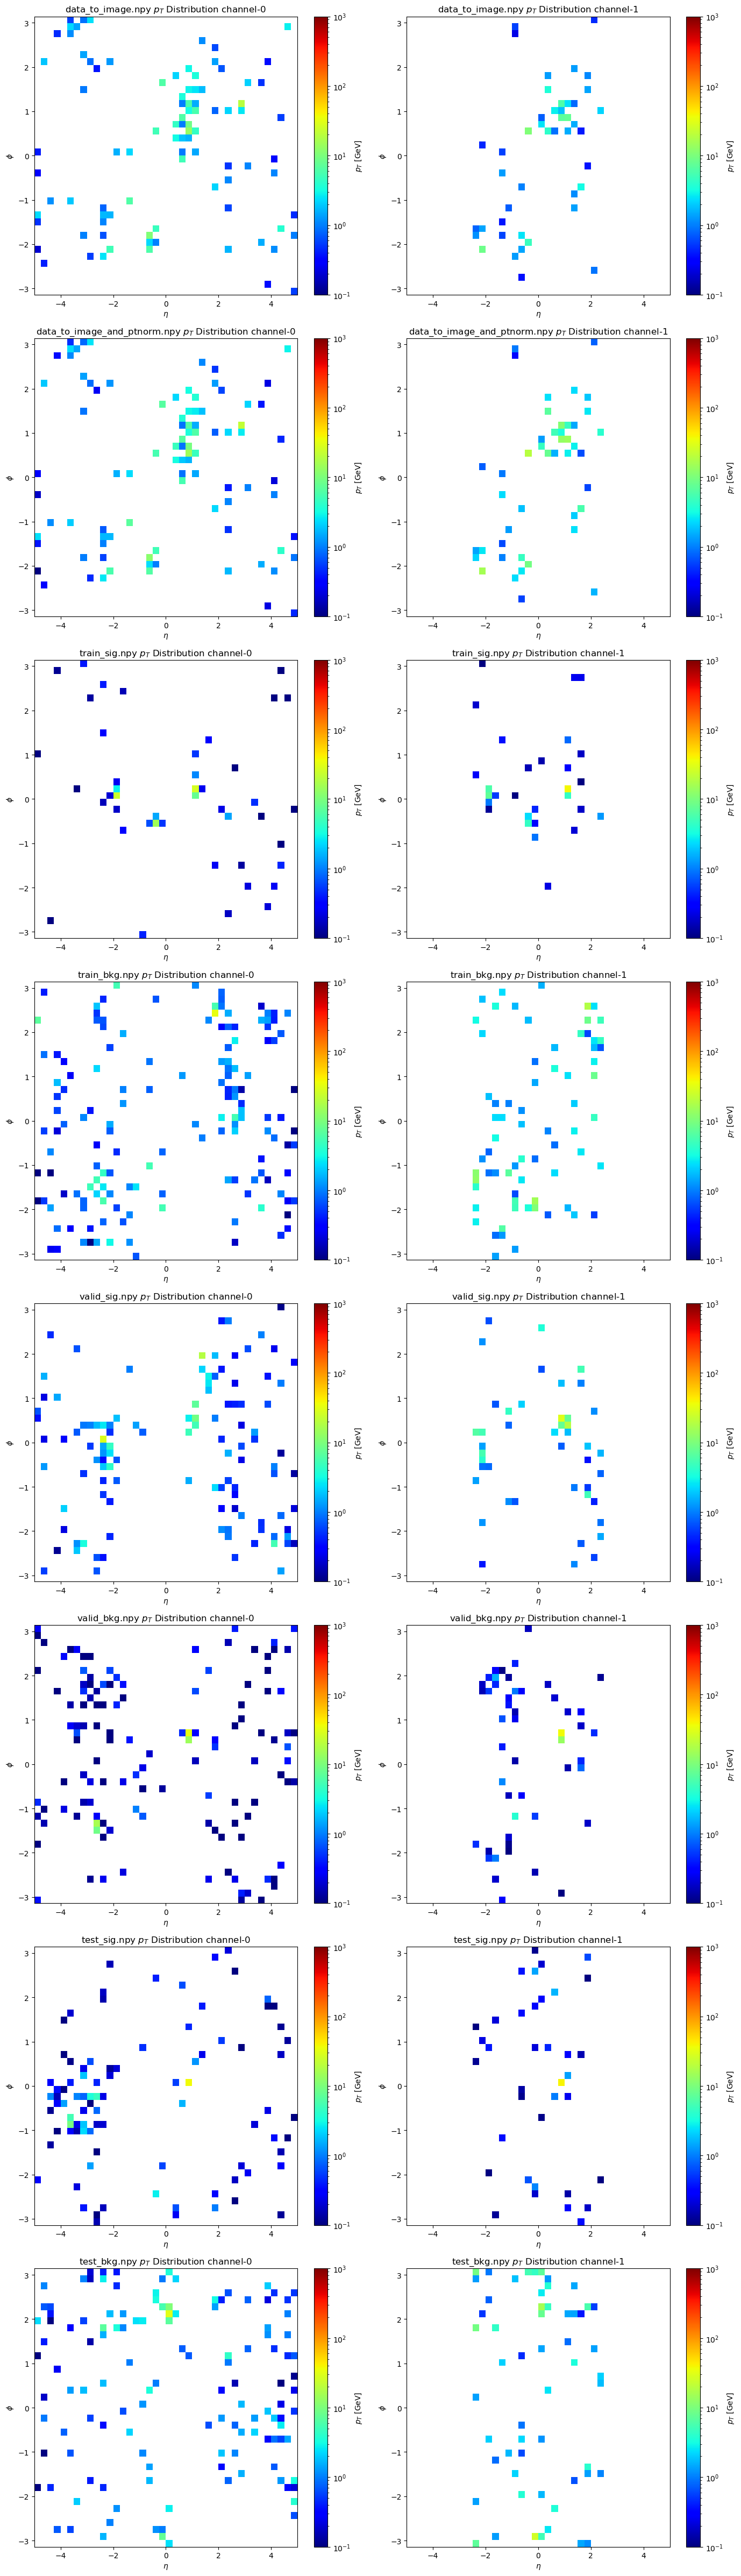

In [6]:
'''Read non-image data'''
data_index = 0  # change the data index here (0~N-1)

for npy_file in ['original_data.npy', 'data_phivar.npy', 'data_phivar_cop.npy', 'data_phivar_cop_flip.npy']:
    data = np.load(npy_path / npy_file, allow_pickle=True).item()
    print(f'\n--- {npy_file} ---')
    print(f'TOWER pt for data {data_index}:', data['TOWER']['pt'][data_index])
    print(f'TRACK pt for data {data_index}:', data['TRACK']['pt'][data_index])
    # print(f'PHOTON pt for data {data_index}:', data['PHOTON']['pt'][data_index])

image_npy_list = ['data_to_image.npy', 'data_to_image_and_ptnorm.npy', 'train_sig.npy', 'train_bkg.npy', 'valid_sig.npy', 'valid_bkg.npy', 'test_sig.npy', 'test_bkg.npy']
fig, axs = plt.subplots(len(image_npy_list), 2, figsize=(14, 6 * len(image_npy_list)))
grid_size = 40
phi_bins = np.linspace(-np.pi, np.pi, grid_size + 1)
eta_bins = np.linspace(-5, 5, grid_size + 1)
for i, npy_file in enumerate(image_npy_list):
    data = np.load(npy_path / npy_file)
    image = data[data_index]
    print(f'\n--- {npy_file} ---')
    print('Image shape:', data.shape)
    print(f'Image for data {data_index}:', image.ravel())

    for j, channel in enumerate(image):
        data_masked = np.ma.masked_where(channel == 0, channel)
        c = axs[i][j].pcolormesh(eta_bins, phi_bins, data_masked, norm=LogNorm(vmin=0.1, vmax=1e3), cmap='jet')
        axs[i][j].set_xlabel(r'$\eta$')
        axs[i][j].set_ylabel(r'$\phi$')
        axs[i][j].set_title(f"{npy_file} $p_T$ Distribution channel-{j}")
        fig.colorbar(c, ax=axs[i][j], label=r'$p_T$ [GeV]')

plt.tight_layout()
plt.show()